Importy

In [5]:
import os
import numpy as np
import skimage as ski
from matplotlib import pyplot as plt
from random import randint
from IPython.display import clear_output
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier as knn
import sklearn.metrics as metrics

Ładowanie klas po nazwach katalogów

In [6]:
def load_classes(path:str):
    lookup = dict()
    reverselookup = dict()
    count = 0
    for j in os.listdir(path):
        if not j.startswith('.'): #bez ukrytych plików
            lookup[j] = count
            reverselookup[count] = j
            count = count+1

    return lookup, reverselookup, count

Ładowanie obrazków i skalowanie do 33% ich rozmiaru w celu ograniczenia zużycia pamięci

In [7]:
def load_images(path:str, lookup:dict):
    x_data = list()
    y_data = list()
    datacount = 0
    for i in range(0, 10):
        for j in os.listdir(path+"/0"+str(i)+"/"):
            if not j.startswith('.'):
                count = 0
                for k in os.listdir(path+"/0"+str(i)+"/"+str(j)+"/"):
                    img = ski.io.imread(fname=path+"/0"+str(i)+"/"+str(j)+"/"+k, as_gray=True)
                    img = ski.transform.rescale(image=img, scale=0.33, anti_aliasing=False )
                    x_data.append(img)
                    count = count+1
                y_values = np.full((count, 1), lookup[j])
                y_data.append(y_values)
                datacount = datacount + count
                clear_output(wait=True)
                print("loaded "+str(datacount)+" images")
                    
    x_data = np.array(x_data, dtype= 'float32')
    y_data = np.array(y_data)
    y_data = y_data.reshape(datacount, 1)
    return x_data, y_data


In [8]:
path = "../data/archive/leapGestRecog"

Wyświetlenie klas

In [9]:
lookup, reverselookup, count = load_classes(path+"/00/")
print(lookup)
print(count)

{'02_l': 0, '06_index': 1, '04_fist_moved': 2, '08_palm_moved': 3, '10_down': 4, '03_fist': 5, '09_c': 6, '05_thumb': 7, '07_ok': 8, '01_palm': 9}
10


In [10]:
x_data, y_data = load_images(path, lookup=lookup)
print("done loading")

loaded 20000 images
done loading


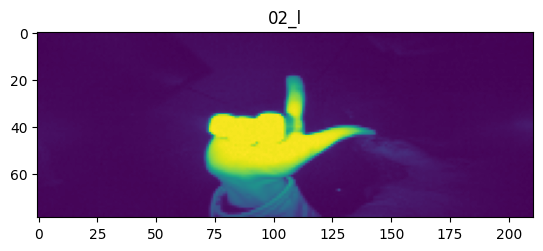

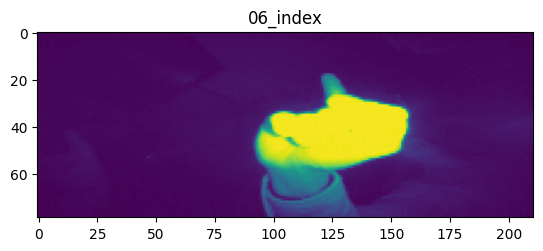

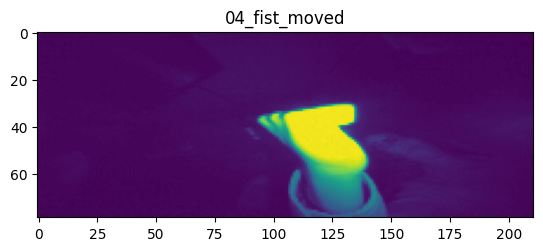

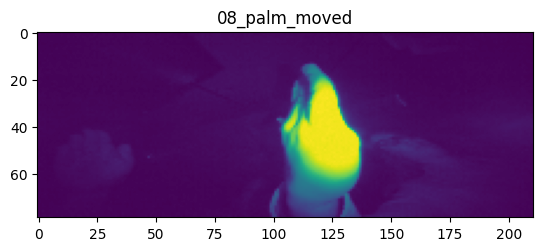

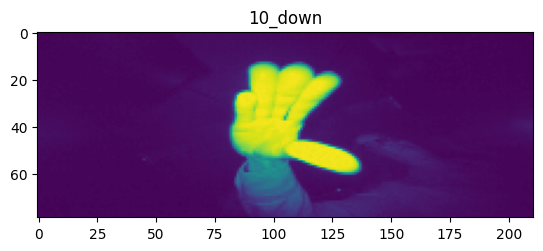

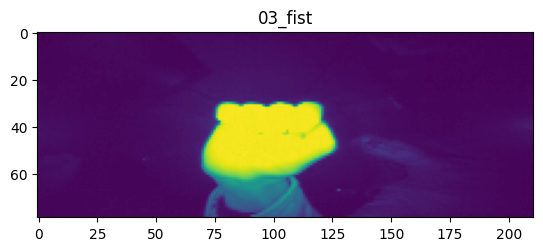

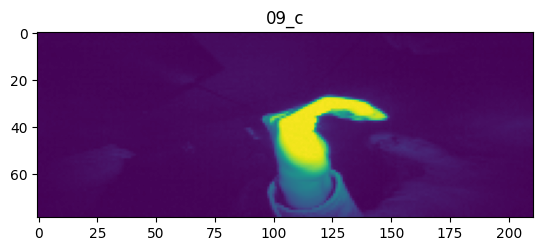

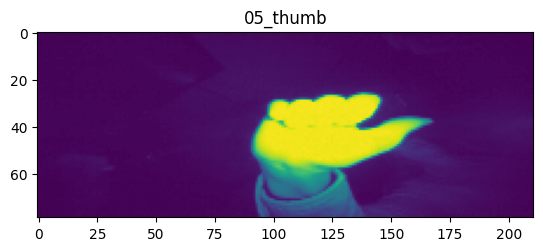

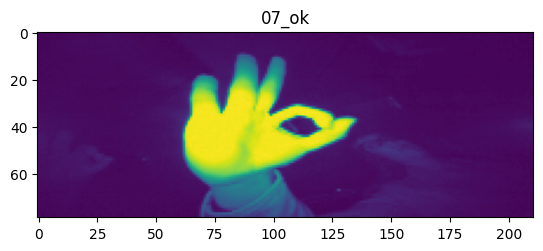

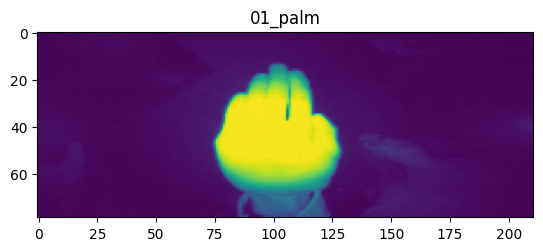

In [7]:

for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()


In [38]:
#print(x_data.shape)
#print(y_data.shape)
X_data = x_data.flatten().reshape(20000, 16669)
Y_data = y_data.flatten()

Zbiory muszą być "spłaszczone", ponieważ klasyfikator knn z sklearn przyjmuje 2 wymiarowe macierze jako wejście, w praktyce oznacza to, że informacje o pozycji kształtu zostaną utracone, ponieważ każdy piksel obrazka będzie zapisany jeden po drugim

Dzielenie zbioru

In [39]:
x_train, x_test, y_train, y_test = tts(X_data,Y_data, test_size=0.3, random_state=16)

<h1>Trenowanie i walidacja modelu (klasyfikator Knn)</h1>

In [16]:
model = knn(n_neighbors=3)
model.fit(x_train, y_train)

preds = model.predict(x_test)
test_preds = model.predict(x_train)

In [14]:
report = metrics.classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       594
           1       1.00      1.00      1.00       572
           2       1.00      1.00      1.00       563
           3       1.00      1.00      1.00       614
           4       1.00      1.00      1.00       637
           5       1.00      1.00      1.00       583
           6       1.00      1.00      1.00       602
           7       1.00      1.00      1.00       620
           8       1.00      1.00      1.00       598
           9       1.00      1.00      1.00       617

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [15]:
acc = metrics.accuracy_score(y_test, preds)
print(acc)

0.9998333333333334


Macierz pomyłek

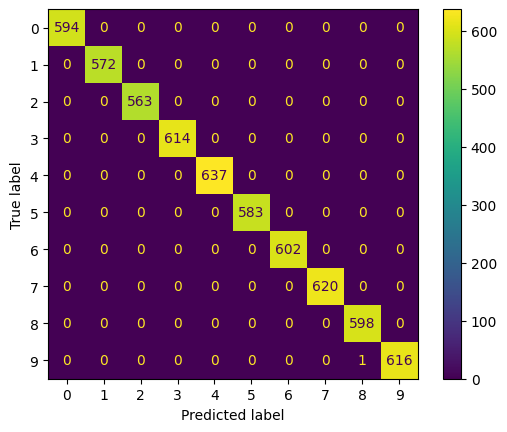

In [17]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

Model knn dla 20 sąsiadów

In [40]:
model = knn(n_neighbors=20)
model.fit(x_train, y_train)

preds = model.predict(x_test)

In [41]:
report = metrics.classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       594
           1       1.00      0.99      1.00       572
           2       0.98      1.00      0.99       563
           3       0.99      1.00      1.00       614
           4       1.00      0.99      1.00       637
           5       0.99      0.98      0.99       583
           6       0.99      1.00      0.99       602
           7       1.00      1.00      1.00       620
           8       1.00      0.99      0.99       598
           9       0.97      0.98      0.98       617

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



In [42]:
acc = metrics.accuracy_score(y_test, preds)
print(acc)

0.9918333333333333


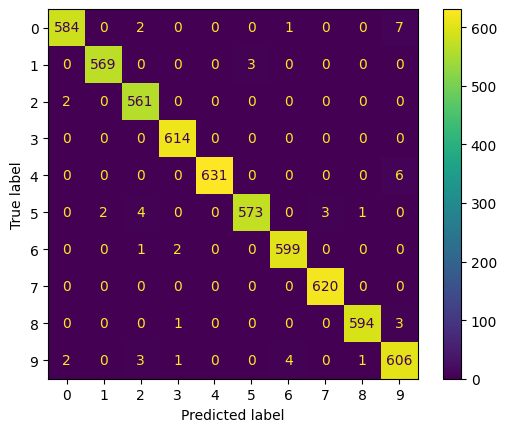

In [43]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

<h1>Trenowanie i walidacja modelu CNN</h1>

In [13]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

Ponowne wczytanie danych

In [12]:
x_train, x_test, y_train, y_test = tts(x_data,y_data, test_size=0.3, random_state=16)

dane wczytywane są ponownie, ponieważ model cnn przyjmuje macierze obrazka, a poprzednio zostały one "spłaszczone", dostajemy 14000 obrazków o wymiarach 79*211

Rozmiar danych wejściowych

In [27]:
x_train.shape

(14000, 79, 211)

Architektura sieci neuronowej

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (7, 21), activation='relu', input_shape=(79, 211, 1))) #ostatni parametr input_shape to ilość kanałów, tutaj obrazy w skali szarości - 1 kanał
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

#funkcja aktywacji relu użyta dla szybkości obliczeń

2024-01-18 19:41:50.689898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 19:41:50.811019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 19:41:50.811239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Trenowanie modelu

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))


2024-01-18 19:41:55.545318: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 933464000 exceeds 10% of free system memory.
2024-01-18 19:41:55.976402: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 933464000 exceeds 10% of free system memory.


Epoch 1/10


2024-01-18 19:41:56.681724: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-18 19:41:57.185768: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2a98768560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 19:41:57.185816: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-18 19:41:57.194258: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705603317.265100   65127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9301

2024-01-18 19:42:04.657615: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 400056000 exceeds 10% of free system memory.
2024-01-18 19:42:04.785677: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 400056000 exceeds 10% of free system memory.


438/438 [==============================] - 10s 15ms/step - loss: 0.2171 - accuracy: 0.9301 - val_loss: 0.0249 - val_accuracy: 0.9940
Epoch 2/10
438/438 [==============================] - 6s 13ms/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 0.0069 - val_accuracy: 0.9973
Epoch 3/10
438/438 [==============================] - 6s 13ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.1181 - val_accuracy: 0.9613
Epoch 4/10
438/438 [==============================] - 6s 13ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0022 - val_accuracy: 0.9990
Epoch 5/10
438/438 [==============================] - 6s 13ms/step - loss: 3.4308e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 6/10
438/438 [==============================] - 6s 13ms/step - loss: 8.7564e-06 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 7/10
438/438 [==============================] - 6s 13ms/step - loss: 5.5385e-06 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.99

In [16]:
preds = model.predict(x_test)

  1/188 [..............................] - ETA: 11s

2024-01-18 19:43:03.736762: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 400056000 exceeds 10% of free system memory.


188/188 [==============================] - 1s 4ms/step


In [17]:
print(preds)

[[ 1.0584788e+00 -2.8925197e+00 -2.8647372e-01 ... -1.6473442e+01
   3.5424106e-02 -3.1343863e+00]
 [ 4.4816446e+00  6.6657076e+00 -1.0037957e+01 ... -2.9252131e+01
  -3.6440521e+01  4.9884991e+01]
 [ 6.5884392e+01  3.8763797e+00 -4.4611115e+01 ...  6.9078879e+00
   3.1077154e+00  2.2575760e+01]
 ...
 [-1.0431961e+01 -2.6605684e+01 -1.5933589e+01 ...  1.4403725e+01
   7.9200971e-01 -1.4838685e+00]
 [-1.1973717e+01  9.6720028e+00 -2.5482402e+00 ...  3.8444927e+00
  -1.0572153e+01 -1.1070569e+01]
 [ 3.2374082e+00 -3.4555578e+00 -3.9431217e+00 ... -5.8713026e+00
  -6.7600379e+00  1.7805382e+01]]


"Ustawienie" najbardziej prawdopodobnej predykcji

In [18]:
predictions = np.argmax(preds, axis=1)

In [19]:
print(predictions)

[3 9 0 ... 4 5 9]


Porównanie metryki sklearn i ewaluacji w tf.keras

In [20]:
acc = metrics.accuracy_score(predictions, y_test)

In [21]:
print(acc)

0.9996666666666667


In [22]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print(test_acc)
print(test_loss)

188/188 - 1s - loss: 0.0010 - accuracy: 0.9997 - 811ms/epoch - 4ms/step
0.999666690826416
0.0010416264412924647


In [23]:
report = metrics.classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       594
           1       1.00      1.00      1.00       572
           2       1.00      1.00      1.00       563
           3       1.00      1.00      1.00       614
           4       1.00      1.00      1.00       637
           5       1.00      1.00      1.00       583
           6       1.00      1.00      1.00       602
           7       1.00      1.00      1.00       620
           8       1.00      1.00      1.00       598
           9       1.00      1.00      1.00       617

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



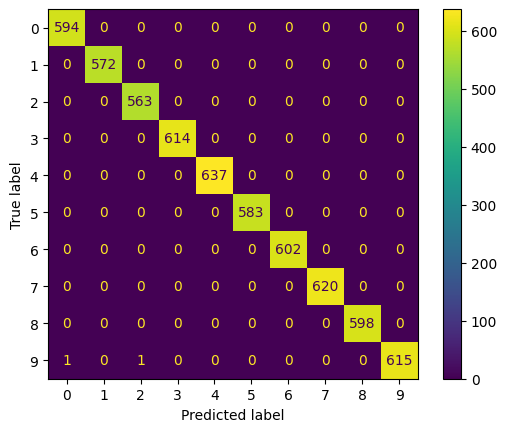

In [24]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()

Trenowanie sieci CNN z ostatnią warstwą z funkcją aktywacji "softmax" na zbiorze o podziale 50%

In [25]:
x_train, x_test, y_train, y_test = tts(x_data,y_data, test_size=0.5, random_state=16)

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (7, 21), activation='relu', input_shape=(79, 211, 1))) #ostatni parametr input_shape to ilość kanałów, tutaj obrazy w skali szarości - 1 kanał
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
313/313 [==============================] - 6s 17ms/step - loss: 0.0153 - accuracy: 0.9966 - val_loss: 0.0138 - val_accuracy: 0.9983
Epoch 2/10
313/313 [==============================] - 5s 15ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0131 - val_accuracy: 0.9982
Epoch 3/10
313/313 [==============================] - 5s 16ms/step - loss: 2.1990e-05 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9986
Epoch 4/10
313/313 [==============================] - 5s 15ms/step - loss: 4.1829e-06 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 0.9986
Epoch 5/10
313/313 [==============================] - 5s 15ms/step - loss: 1.4937e-06 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9985
Epoch 6/10
313/313 [==============================] - 5s 15ms/step - loss: 8.4854e-07 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9986
Epoch 7/10
313/313 [==============================] - 5s 15ms/step - loss: 6.3027e-07 - accuracy: 1.0000 - val_loss: 0.0112 - 

In [31]:
preds = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


In [32]:
predictions = np.argmax(preds, axis=1)

In [33]:
acc = metrics.accuracy_score(predictions, y_test)

In [34]:
print(acc)

0.9985


In [35]:
report = metrics.classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1020
           1       1.00      0.99      0.99       980
           2       1.00      1.00      1.00       985
           3       1.00      1.00      1.00       998
           4       1.00      1.00      1.00      1022
           5       1.00      1.00      1.00       997
           6       1.00      1.00      1.00      1017
           7       1.00      1.00      1.00       980
           8       1.00      1.00      1.00       983
           9       1.00      1.00      1.00      1018

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



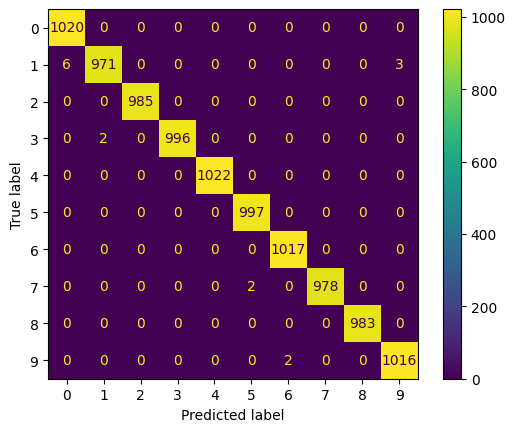

In [36]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()
#dziwne, że na tej macierzy pomyłek nie ma mnie ~ Wojtek